In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
df = pd.read_csv('data/to_model.csv', index_col = 0)

In [3]:
df.head()

,age,Medu,Fedu,failures,traveltime,studytime,Dalc,Walc,absences,Final_grade,goout,famrel,guardian,Mjob,Fjob,sex,Pstatus,romantic
0,18,4,4,0,2,2,1,1,6,6,4,4,mother,at_home,teacher,F,A,no
1,17,1,1,0,1,2,1,1,4,6,3,5,father,at_home,other,F,T,no
2,15,1,1,3,1,2,2,3,10,10,2,4,mother,at_home,other,F,T,no
3,15,4,2,0,1,3,1,1,2,15,2,3,mother,health,services,F,T,yes
4,16,3,3,0,1,2,1,2,4,10,2,4,father,other,other,F,T,no


In [4]:
df2 = pd.get_dummies(df, drop_first = True)

In [5]:
from sklearn.model_selection import train_test_split
import random
X_train, X_test, y_train, y_test = train_test_split(df2, df2.Final_grade, test_size=0.2, random_state=10)
print(X_train.shape, X_test.shape)

(316, 25) (79, 25)


In [6]:
X_train.head()

,age,Medu,Fedu,failures,traveltime,studytime,Dalc,Walc,absences,Final_grade,...,Mjob_other,Mjob_services,Mjob_teacher,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,sex_M,Pstatus_T,romantic_yes
266,17,3,1,0,1,2,3,4,2,10,...,0,1,0,0,1,0,0,1,1,1
352,18,1,3,1,1,1,2,3,7,8,...,0,0,0,0,0,1,0,1,1,1
97,16,2,1,0,1,2,1,1,2,10,...,1,0,0,0,1,0,0,0,1,1
167,16,4,2,0,1,2,1,1,0,16,...,0,0,0,0,0,1,0,0,1,1
280,17,4,1,0,2,1,2,4,30,8,...,0,1,0,0,1,0,0,1,0,1


First running mutual information to get intuition

In [7]:
from sklearn import feature_selection
mutual_info = feature_selection.mutual_info_classif(X_train, y_train, discrete_features=True)

In [8]:
pd.DataFrame({'minfo': mutual_info, 'col': X_train.columns}).sort_values('minfo', ascending=False)

,minfo,col
9,2.593763,Final_grade
8,0.633463,absences
3,0.163247,failures
0,0.137014,age
1,0.133067,Medu
7,0.127030,Walc
10,0.124776,goout
2,0.100426,Fedu
5,0.097476,studytime
6,0.096018,Dalc


In [9]:
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant

First model with best variable according to mutual info

In [10]:
cols_to_fit = [
#     'Final_grade',
 'absences',
#  'failures',
#  'age',
#  'Medu',
#  'Walc',
#  'goout',
#  'Fedu',
#  'studytime',
#  'Dalc',
#  'famrel',
#  'traveltime',
#  'romantic_yes',
#  'Mjob_services',
#  'Fjob_teacher',
#  'Fjob_services',
#  'sex_M',
#  'Fjob_other',
#  'Mjob_health',
#  'Mjob_other',
#  'guardian_other',
#  'Mjob_teacher',
#  'Fjob_health',
#  'Pstatus_T',
#  'guardian_mother'
]

mod = sm.OLS(X_train['Final_grade'], add_constant(X_train[cols_to_fit]))
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Final_grade   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.121
Date:                Thu, 14 May 2020   Prob (F-statistic):              0.291
Time:                        10:55:06   Log-Likelihood:                -936.00
No. Observations:                 316   AIC:                             1876.
Df Residuals:                     314   BIC:                             1884.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.1411      0.338     30.033      0.000       9.477      10.805
absences       0.0396      0.037      1.059      0.291      -0.034       0.113
==============================================================================
Omnibus:                       21.388   Durbin-Watson:                   1.919
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.232
Skew:                          -0.677   Prob(JB):                     5.47e-06
Kurtosis:                       3.072   Cond. No.                         11.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Performance with R2 = 0.004 is mediocre. Absences is not significant. Probably these is nonlinear?

Now fitting all variables

In [11]:
cols_to_fit = [
#     'Final_grade',
 'absences',
 'failures',
 'age',
 'Medu',
 'Walc',
 'goout',
 'Fedu',
 'studytime',
 'Dalc',
 'famrel',
 'traveltime',
 'romantic_yes',
 'Mjob_services',
 'Fjob_teacher',
 'Fjob_services',
 'sex_M',
 'Fjob_other',
 'Mjob_health',
 'Mjob_other',
 'guardian_other',
 'Mjob_teacher',
 'Fjob_health',
 'Pstatus_T',
 'guardian_mother'
]

mod = sm.OLS(X_train['Final_grade'], add_constant(X_train[cols_to_fit]))
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Final_grade   R-squared:                       0.245
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     3.926
Date:                Thu, 14 May 2020   Prob (F-statistic):           1.10e-08
Time:                        10:55:06   Log-Likelihood:                -892.25
No. Observations:                 316   AIC:                             1835.
Df Residuals:                     291   BIC:                             1928.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              14.6387      4.147      3.530      0.000       6.478      22.800
absences            0.0811      0.037      2.211      0.028       0.009       0.153
failures           -2.0369      0.373     -5.461      0.000      -2.771      -1.303
age                -0.1444      0.219     -0.659      0.510      -0.576       0.287
Medu                0.3997      0.359      1.114      0.266      -0.306       1.106
Walc                0.2342      0.281      0.833      0.406      -0.319       0.788
goout              -0.6630      0.250     -2.651      0.008      -1.155      -0.171
Fedu               -0.1397      0.308     -0.453      0.651      -0.746       0.467
studytime           0.4461      0.331      1.349      0.179      -0.205       1.097
Dalc               -0.0487      0.385     -0.127      0.899      -0.807       0.709
famrel              0.2891      0.293      0.988      0.324      -0.287       0.865
traveltime         -0.6728      0.374     -1.797      0.073      -1.410       0.064
romantic_yes       -0.8878      0.535     -1.660      0.098      -1.941       0.165
Mjob_services       0.6664      0.887      0.752      0.453      -1.079       2.412
Fjob_teacher        0.2636      1.458      0.181      0.857      -2.606       3.133
Fjob_services      -1.0848      1.189     -0.912      0.362      -3.426       1.256
sex_M               1.2146      0.541      2.245      0.026       0.150       2.279
Fjob_other         -1.1553      1.171     -0.986      0.325      -3.460       1.150
Mjob_health         1.3964      1.271      1.099      0.273      -1.105       3.898
Mjob_other         -0.6897      0.809     -0.853      0.395      -2.282       0.903
guardian_other     -0.0431      1.101     -0.039      0.969      -2.210       2.124
Mjob_teacher       -0.7496      1.130     -0.663      0.508      -2.974       1.474
Fjob_health        -0.3151      1.690     -0.186      0.852      -3.642       3.011
Pstatus_T          -0.7623      0.842     -0.905      0.366      -2.420       0.896
guardian_mother    -0.6140      0.643     -0.955      0.340      -1.879       0.651
==============================================================================
Omnibus:                       21.250   Durbin-Watson:                   1.900
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.555
Skew:                          -0.647   Prob(JB):                     7.68e-06
Kurtosis:                       3.342   Cond. No.                         343.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Performance got better, with R2 = 0.245.

Now fitting a model with only one variable at a time.

In [12]:
cols_to_fit = [
#     'Final_grade',
 'absences',
 'failures',
 'age',
 'Medu',
 'Walc',
 'goout',
 'Fedu',
 'studytime',
 'Dalc',
 'famrel',
 'traveltime',
 'romantic_yes',
 'Mjob_services',
 'Fjob_teacher',
 'Fjob_services',
 'sex_M',
 'Fjob_other',
 'Mjob_health',
 'Mjob_other',
 'guardian_other',
 'Mjob_teacher',
 'Fjob_health',
 'Pstatus_T',
 'guardian_mother'
]

r2 = []

for col in cols_to_fit:
    mod = sm.OLS(X_train['Final_grade'], add_constant(X_train[col]))
    res = mod.fit()
    r2.append((col, res.rsquared))

In [13]:
r2_df = pd.DataFrame(r2, columns = ['col', 'r2']).sort_values('r2', ascending = False)
r2_df.head(5)

,col,r2
1,failures,0.127893
3,Medu,0.047465
6,Fedu,0.028789
5,goout,0.025503
2,age,0.023633


Failures is the best one - 3 times as good as the second one. 

Now trying the same thing as above with testing one variable at a time, but using first squared variables, and then square rooted (an attempt to capture nonlinearity)

In [14]:
cols_to_fit = [
#     'Final_grade',
 'absences',
 'failures',
 'age',
 'Medu',
 'Walc',
 'goout',
 'Fedu',
 'studytime',
 'Dalc',
 'famrel',
 'traveltime',
 'romantic_yes',
 'Mjob_services',
 'Fjob_teacher',
 'Fjob_services',
 'sex_M',
 'Fjob_other',
 'Mjob_health',
 'Mjob_other',
 'guardian_other',
 'Mjob_teacher',
 'Fjob_health',
 'Pstatus_T',
 'guardian_mother'
]

r2 = []

for col in cols_to_fit:
    mod = sm.OLS(X_train['Final_grade'], add_constant(np.power(X_train, 2)[col]))
    res = mod.fit()
    r2.append((col, res.rsquared))

In [15]:
r2_df = pd.DataFrame(r2, columns = ['col', 'r2']).sort_values('r2', ascending = False)
r2_df.head(5)

,col,r2
1,failures,0.105651
3,Medu,0.054122
6,Fedu,0.029472
5,goout,0.028201
2,age,0.023112


Nothing changed here - top 5 predictors are still the same. Now trying square roots.

In [16]:
cols_to_fit = [
#     'Final_grade',
 'absences',
 'failures',
 'age',
 'Medu',
 'Walc',
 'goout',
 'Fedu',
 'studytime',
 'Dalc',
 'famrel',
 'traveltime',
 'romantic_yes',
 'Mjob_services',
 'Fjob_teacher',
 'Fjob_services',
 'sex_M',
 'Fjob_other',
 'Mjob_health',
 'Mjob_other',
 'guardian_other',
 'Mjob_teacher',
 'Fjob_health',
 'Pstatus_T',
 'guardian_mother'
]

r2 = []

for col in cols_to_fit:
    mod = sm.OLS(X_train['Final_grade'], add_constant(np.power(X_train, 1/2)[col]))
    res = mod.fit()
    r2.append((col, res.rsquared))

In [17]:
r2_df = pd.DataFrame(r2, columns = ['col', 'r2']).sort_values('r2', ascending = False)
r2_df.head(5)

,col,r2
1,failures,0.126626
3,Medu,0.035716
6,Fedu,0.024323
2,age,0.023833
0,absences,0.023581


This is almost the same as previously - except that absences entered the top 5 and goout dropped. absences was indicated as important predictor by mutual info

In [18]:
from sklearn.linear_model import LinearRegression

In [19]:
cols_to_fit = [
#     'Final_grade',
 'absences',
 'failures',
 'age',
 'Medu',
 'Walc',
 'goout',
 'Fedu',
 'studytime',
 'Dalc',
 'famrel',
 'traveltime',
 'romantic_yes',
 'Mjob_services',
 'Fjob_teacher',
 'Fjob_services',
 'sex_M',
 'Fjob_other',
 'Mjob_health',
 'Mjob_other',
 'guardian_other',
 'Mjob_teacher',
 'Fjob_health',
 'Pstatus_T',
 'guardian_mother'
]


mod = LinearRegression()
mod.fit(X_train[cols_to_fit], y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [20]:
from sklearn.metrics import r2_score

In [21]:
r2_score(y_train, mod.predict(X_train[cols_to_fit]))

0.24458652935703795

In [22]:
r2_score(y_test, mod.predict(X_test[cols_to_fit]))

0.06602771492040727

Performance on test set is very poor

In [23]:
from sklearn.feature_selection import RFE, RFECV

In [24]:
rfe = RFE(mod, n_features_to_select = 1)
rfe.fit(X_train[cols_to_fit], y_train)
# rfe.ranking_
pd.DataFrame({'col': cols_to_fit, 'rank': rfe.ranking_}).sort_values('rank').head(7)

,col,rank
1,failures,1
17,Mjob_health,2
12,Mjob_services,3
16,Fjob_other,4
14,Fjob_services,5
15,sex_M,6
22,Pstatus_T,7


Failures is again ranked as the best, while importance of student's parents is visible now.

Now adding prediction on test set for gradually increasing number of parameters

In [25]:
rankings = pd.DataFrame({'col': cols_to_fit, 'rank': rfe.ranking_}).sort_values('rank')

r2_vals = []

for i in range(1, len(rankings)):
#     pass
    features = list(rankings.iloc[:i,0])
#     print(f'fitting for {i}')
    mod = LinearRegression()
    mod.fit(X_train[features], y_train)
    r2_train = r2_score(y_train, mod.predict(X_train[features]))
    r2_test = r2_score(y_test, mod.predict(X_test[features]))
#     print(f'Train: {r2_train}')
#     print(f'Test: {r2_test}')
    r2_vals.append((r2_train, r2_test))
    
    
#     print(i)

Train: 0.1278930643513717
Test: 0.13678649132281528
Train: 0.13525006008467177
Test: 0.16245282502345326
Train: 0.15509528687848406
Test: 0.17620977805139526
Train: 0.15840283864424165
Test: 0.16737555430861784
Train: 0.16454115701559857
Test: 0.1489404398442844
Train: 0.17933123254732775
Test: 0.17299375515015825
Train: 0.18283891976518418
Test: 0.1685128381473151
Train: 0.18856489230781148
Test: 0.18676160662241792
Train: 0.1977303296894214
Test: 0.14987100995092595
Train: 0.2127537715711444
Test: 0.13022222277531936
Train: 0.2149680362733044
Test: 0.11046818067160691
Train: 0.21652916299889047
Test: 0.08636279313646944
Train: 0.21664941244213265
Test: 0.08840231351138317
Train: 0.22257259044481703
Test: 0.09549007716055757
Train: 0.22526839915314356
Test: 0.10852258574101559
Train: 0.2283554542918097
Test: 0.1040048428009589
Train: 0.22842472025413785
Test: 0.10622068072889812
Train: 0.23024186186915307
Test: 0.10740792584057923
Train: 0.23106372560664723
Test: 0.1121175037460802
Tr

In [26]:
rfe_r2_df = pd.DataFrame(r2_vals, columns = ['train', 'test']).reset_index()

#### Comparison of R^2 for train and validation sets depending on number of features

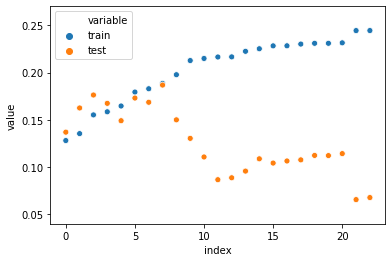

In [27]:
sns.scatterplot(x = 'index', y= 'value', hue = 'variable', data = pd.melt(rfe_r2_df, id_vars = 'index'))

So, about 8 first features gives similar outcome for train and test set, anythig more than than ruins validation score

In [28]:
list(rankings.iloc[:8,0])

['failures',
 'Mjob_health',
 'Mjob_services',
 'Fjob_other',
 'Fjob_services',
 'sex_M',
 'Pstatus_T',
 'romantic_yes']

Fitting linear model with these variables

In [29]:
cols_to_fit = list(rankings.iloc[:8,0])

mod = sm.OLS(X_train['Final_grade'], add_constant(X_train[cols_to_fit]))
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Final_grade   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     8.918
Date:                Thu, 14 May 2020   Prob (F-statistic):           5.38e-11
Time:                        10:55:07   Log-Likelihood:                -903.55
No. Observations:                 316   AIC:                             1825.
Df Residuals:                     307   BIC:                             1859.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            12.2219      1.005     12.155      0.000      10.243      14.200
failures         -2.2667      0.329     -6.889      0.000      -2.914      -1.619
Mjob_health       2.1717      0.928      2.341      0.020       0.347       3.997
Mjob_services     1.3811      0.572      2.414      0.016       0.255       2.507
Fjob_other       -1.2690      0.678     -1.870      0.062      -2.604       0.066
Fjob_services    -1.0669      0.763     -1.398      0.163      -2.568       0.434
sex_M             1.0872      0.487      2.233      0.026       0.129       2.045
Pstatus_T        -0.9779      0.819     -1.193      0.234      -2.590       0.635
romantic_yes     -0.7652      0.520     -1.472      0.142      -1.788       0.258
==============================================================================
Omnibus:                       27.067   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.423
Skew:                          -0.739   Prob(JB):                     1.50e-07
Kurtosis:                       3.449   Cond. No.                         8.96
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

From statistical inference point of view, Father job and romantic variables should be ommited as they are statistically insignificant

#### Lasso regression

Now I'm trying to fit Lasso regression - as a mean of feature selection

In [30]:
from sklearn.linear_model import Lasso

In [31]:
cols_to_fit = [
#     'Final_grade',
 'absences',
 'failures',
 'age',
 'Medu',
 'Walc',
 'goout',
 'Fedu',
 'studytime',
 'Dalc',
 'famrel',
 'traveltime',
 'romantic_yes',
 'Mjob_services',
 'Fjob_teacher',
 'Fjob_services',
 'sex_M',
 'Fjob_other',
 'Mjob_health',
 'Mjob_other',
 'guardian_other',
 'Mjob_teacher',
 'Fjob_health',
 'Pstatus_T',
 'guardian_mother'
]


In [32]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import random
kf = KFold(n_splits=3, shuffle=True, random_state=random.randint(0,10000))
alphas = np.linspace(0.01, 0.5, 80)

scores = []

for alpha in alphas:
    r2_train = []
    r2_test = []
    for train, test in kf.split(X_train.index.values):
        
        reg = Lasso(alpha = alpha)
        reg.fit(X_train.iloc[train][cols_to_fit], X_train.iloc[train]['Final_grade'])
        predsTrain = reg.predict(X_train.iloc[train][cols_to_fit])
        preds = reg.predict(X_train.iloc[test][cols_to_fit])
        
        r2_test.append(r2_score(X_train.iloc[test].Final_grade, preds))
        r2_train.append(r2_score(X_train.iloc[train].Final_grade, predsTrain))
    a = (alpha, np.mean(r2_test), np.mean(r2_train))
    scores.append(a)    
#     print(a)


In [33]:
r2_scores_lasso = pd.DataFrame(scores, columns = ['alpha', 'test', 'train'])

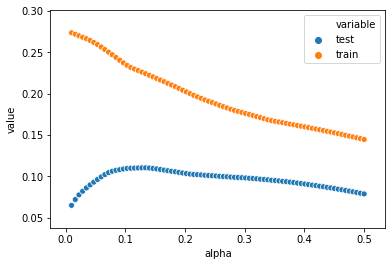

In [34]:
sns.scatterplot(x = 'alpha', y= 'value', hue = 'variable', data = pd.melt(r2_scores_lasso, id_vars = 'alpha'))

Alpha around 0.1-0.2 seems correct. The score is dropping very slowly, so to obtain parsimonious model I have used alpha = 0.2

In [35]:
mod = Lasso(alpha = 0.2)
mod.fit(X_train[cols_to_fit], y_train)

Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [36]:
pd.DataFrame({'col': cols_to_fit, 'coef':mod.coef_})

,col,coef
0,absences,0.059949
1,failures,-1.679102
2,age,-0.092547
3,Medu,0.412100
4,Walc,0.000000
5,goout,-0.411050
6,Fedu,0.000000
7,studytime,0.000000
8,Dalc,0.000000
9,famrel,0.000000


In [37]:
r2_score(y_train, mod.predict(X_train[cols_to_fit]))

0.18259759159789268

In [38]:
r2_score(y_test, mod.predict(X_test[cols_to_fit]))

0.10054218645164259